FCN implementation translated to Keras, inspired by: 
    - https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/ 
    - https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semanticsegmentation.html 

In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Add, Reshape, Lambda
from keras.models import Model
from keras.activations import softmax
from keras.applications.vgg16 import VGG16
import keras.losses
from keras import backend as K
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
path_annot = r'C:\Users\hanson\Documents\thesis\PCDADBA\annots'
path_train = r'C:\Users\hanson\Documents\thesis\PCDADBA\train'
os.chdir(path_annot)
annot = [plt.imread(img) for img in os.listdir(path_annot)]
os.chdir(path_train)
train = [plt.imread(img) for img in os.listdir(path_train)]

In [3]:
train = np.array([cv2.resize(x,(224,224),interpolation=cv2.INTER_NEAREST) for x in train])/255
annot = np.array([cv2.resize(x,(224,224),interpolation=cv2.INTER_NEAREST) for x in annot])*255

In [4]:
train.shape

(6, 224, 224, 3)

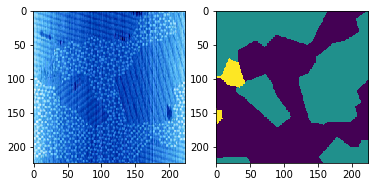

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(train[0])
ax[1].imshow(annot[0])

In [4]:
r,s = 224,224
no_classes = 3
labels_tensor = K.one_hot(annot, no_classes)

In [5]:
# Loading pre-trained vgg16 model and removing last couple of fully-connected layers\
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_out = vgg16.outputs[0]
vgg16.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
fcn1 = Conv2D(filters=no_classes, kernel_size=1, name="fcn1")(vgg_out)
fcn2 = Conv2DTranspose(filters=vgg16.layers[14].output_shape[-1], 
                              kernel_size=4, strides=(2, 2), padding='same', name='fcn2')(fcn1)
fcn3 = Add()([fcn2, vgg16.layers[14].output])
fcn4 = Conv2DTranspose(filters=vgg16.layers[10].output_shape[-1],
                      kernel_size=4, strides=(2, 2), padding='same', name='fcn4')(fcn3)
fcn5 = Add()([fcn4, vgg16.layers[10].output])
fcn6 = Conv2DTranspose(filters=no_classes, kernel_size=16, strides=(8,8), 
                      padding='same', name='fcn6')(fcn5)
fcn6.set_shape([None,224,224,no_classes])
def logits_to_output(fcn6):
    output = softmax(fcn6)
    return output
output = Lambda(logits_to_output)(fcn6)

In [7]:
output, labels_tensor

(<tf.Tensor 'lambda_1/truediv:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'one_hot:0' shape=(6, 224, 224, 3) dtype=float32>)

In [8]:
model = Model(inputs=vgg16.inputs, outputs=output)
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [9]:
model.fit(train[:5], labels_tensor[:5], verbose=1, steps_per_epoch=3, epochs=25)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/25
3/3 [==============================] - 31s 10s/step - loss: 1.1878
Epoch 2/25
3/3 [==============================] - 26s 9s/step - loss: 0.7861
Epoch 3/25
3/3 [==============================] - 26s 9s/step - loss: 0.6765
Epoch 4/25
3/3 [==============================] - 26s 9s/step - loss: 0.5850
Epoch 5/25
3/3 [==============================] - 25s 8s/step - loss: 0.4896
Epoch 6/25
3/3 [==============================] - 26s 9s/step - loss: 0.4355
Epoch 7/25
3/3 [==============================] - 26s 9s/step - loss: 0.3668
Epoch 8/25
3/3 [==============================] - 26s 9s/step - loss: 0.3334
Epoch 9/25
3/3 [==============================] - 26s 9s/step - loss: 0.3140
Epoch 10/25
3/3 [==============================] - 26s 9s/step - loss: 0.2840
Epoch 11/25
3/3 [==============================] - 25s 8s/step - loss: 0.2197
Epoch 12/25
3/3 [=======

In [10]:
N = 2
pred_img = train[-N:]
pred = model.predict(pred_img)

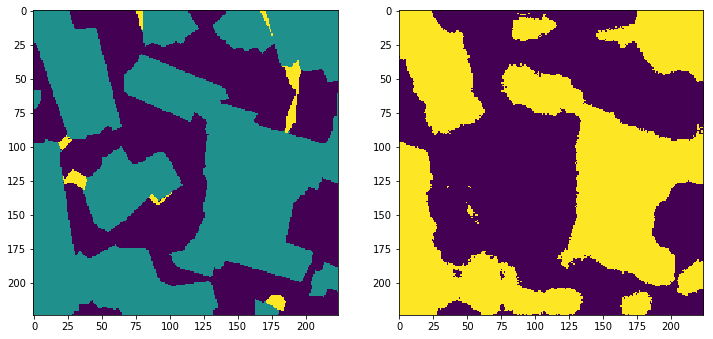

In [11]:
p = np.argmax(pred,axis=3)
fig,ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(annot[-1])
ax[1].imshow(p[1])

In [13]:
# Quick accuracy metric: no_correct_pixels/no_total
coord = []
pp,aa = list(p[0]),list(annot[-2])
for x,y in zip(np.nditer(p[0]),np.nditer(annot[-2])):
    if x!=y:
        coord.append(('fubar'))
accuracy = 1-(len(coord)/(224*224))
print(accuracy)

0.9163942920918368


 NB : TCB:
accuracy w/o preprocessing : 0.8402822066326531
accuracy w/ preprocessing: 0.6571468431122449
PCDADBA:
accuracy w/o preprocessing: 0.9073860012755102

In [ ]:
:]